## Advanced Lane Finding

The goal of this project is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

### The algorithm

The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Import Packages

In [1]:
from experiments import *
from IPython.display import HTML
%matplotlib inline

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [2]:
cal_fnames = [path for path in glob.iglob('camera_cal/*.jpg', recursive=True)]
cal_images, cal_gray_images = read_images(cal_fnames)
objpoints, imgpoints, cal_upd_images = get_chessboard_corners(cal_images, cal_gray_images)

cal_selected_idx = 0
cal_test_image = cal_images[cal_selected_idx]
cal_test_image_gray = cal_gray_images[cal_selected_idx]

cal_undistorted_image = correct_distortion(cal_test_image, objpoints, imgpoints)

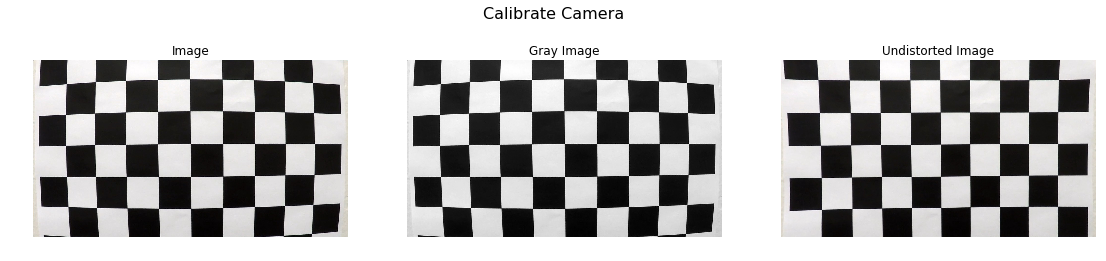

In [3]:
images_to_show = [cal_test_image, cal_test_image_gray, cal_undistorted_image]
labels_to_show = ["Image", "Gray Image", "Undistorted Image"]
show_images(images_to_show, labels_to_show, cols=len(images_to_show), title="Calibrate Camera")

### Apply a distortion correction to raw images

In [4]:
example_fnames = ["test_images/straight_lines1.jpg", "test_images/test2.jpg"]
example_images, _ = read_images(example_fnames)

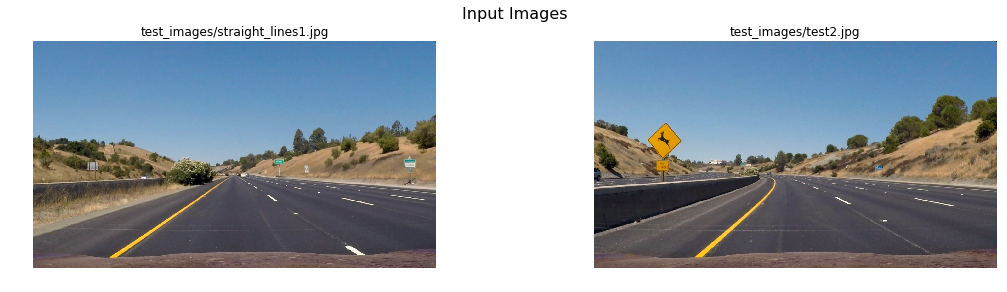

In [5]:
show_images(example_images, labels=example_fnames, cols=len(example_images), title="Input Images")

In [6]:
example_selected_idx = 0
example_test_image = example_images[example_selected_idx]
original_test_image = example_test_image

example_undistorted_image = correct_distortion(example_test_image, objpoints, imgpoints)

example_cropped_undistorted_image = apply_crop_bottom(example_undistorted_image)

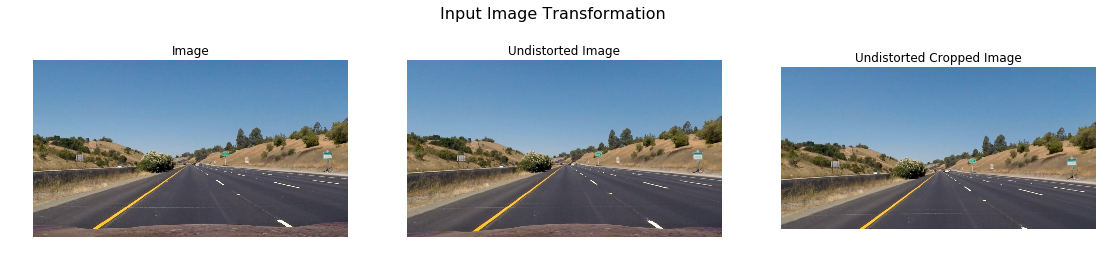

In [7]:
images_to_show = [example_test_image, example_undistorted_image,
                  example_cropped_undistorted_image]
labels_to_show = ["Image", "Undistorted Image", "Undistorted Cropped Image"]
show_images(images_to_show, labels=labels_to_show, cols=len(images_to_show),
                title="Input Image Transformation")

In [8]:
example_test_image = example_cropped_undistorted_image
example_height, example_width = example_cropped_undistorted_image.shape[:2]

print("example image width: ", example_width)
print("example image height: ", example_height)

example image width:  1280
example image height:  660


### Apply a perspective transform to rectify binary image ("birds-eye view")

In [9]:
height, width = example_test_image.shape[:2]

In [10]:
example_warped_image, M, Minv = apply_warp(example_test_image)

In [11]:
src_top_left = (width * top_left_x, height * top_left_y)
src_top_right = (width * top_right_x, height * top_right_y)
src_bottom_right = (width * bottom_right_x, height * bottom_right_y)
src_bottom_left = (width * bottom_left_x, height * bottom_left_y)

trg_top_left = (width * bottom_left_x, 0)
trg_top_right = (width * bottom_right_x, 0)
trg_bottom_right = (width * bottom_right_x, height * bottom_right_y)
trg_bottom_left = (width * bottom_left_x, height * bottom_left_y)

In [12]:
print("Source")
print("top_left: ", src_top_left)
print("top_right: ", src_top_right)
print("bottom_right: ", src_bottom_right)
print("bottom_left: ", src_bottom_left)

Source
top_left:  (608.0, 448.8)
top_right:  (691.2, 448.8)
bottom_right:  (1004.8000000000001, 660.0)
bottom_left:  (313.6, 660.0)


In [13]:
print("Destination")
print("top_left: ", trg_top_left)
print("top_right: ", trg_top_right)
print("bottom_right: ", trg_bottom_right)
print("bottom_left: ", trg_bottom_left)

Destination
top_left:  (313.6, 0)
top_right:  (1004.8000000000001, 0)
bottom_right:  (1004.8000000000001, 660.0)
bottom_left:  (313.6, 660.0)


In [14]:
example_test_image_roi = example_test_image.copy()
example_test_image_trg_roi = example_test_image.copy()
example_test_image_warped_roi = example_test_image.copy()

src_vertices = np.array([[src_top_left, src_top_right, src_bottom_right, src_bottom_left]], dtype=np.int32)
trg_vertices = np.array([[trg_top_left, trg_top_right, trg_bottom_right, trg_bottom_left]], dtype=np.int32)

cv2.polylines(example_test_image_roi, [src_vertices], isClosed=True, color=(0, 255, 255), thickness=2)

src = np.float32(src_vertices)
trg = np.float32(trg_vertices)

example_test_image_warped_roi, M, Minv = warp_image(example_test_image_warped_roi, src, trg)
example_test_image_warped_roi = cv2.polylines(example_test_image_warped_roi, [trg_vertices], 
                                                  isClosed=True, color=(0, 255, 255), thickness=2)

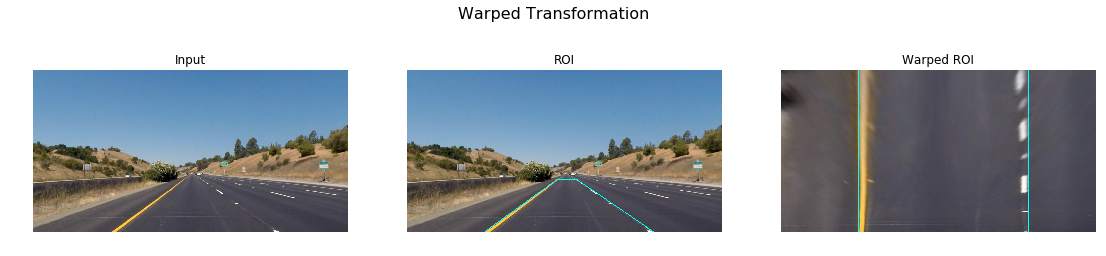

In [15]:
images_to_show = [example_test_image, example_test_image_roi, example_test_image_warped_roi]
labels_to_show = ["Input", "ROI", "Warped ROI"]
show_images(images_to_show, labels=labels_to_show, cols=len(images_to_show), title="Warped Transformation")

### Use color transforms, gradients, etc., to create a thresholded binary image

In [16]:
example_warped_wb_image = apply_color_mask(example_warped_image)
example_threshold_wb_image = apply_threshold(example_warped_image)
example_combined_image = np.bitwise_and(example_warped_wb_image, example_threshold_wb_image)

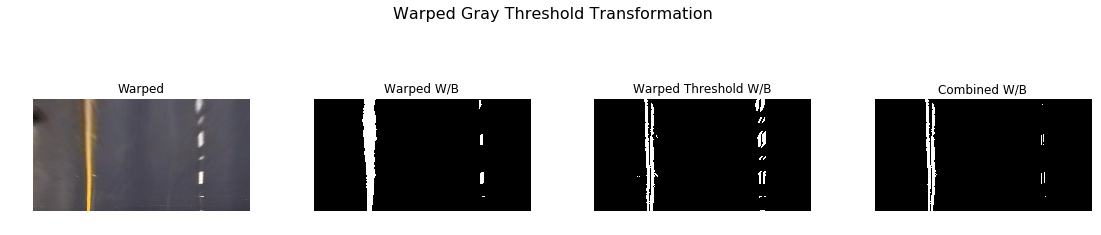

In [17]:
images_to_show = [example_warped_image, example_warped_wb_image, example_threshold_wb_image, example_combined_image]
labels_to_show = ["Warped", "Warped W/B", "Warped Threshold W/B", "Combined W/B"]
show_images(images_to_show, labels=labels_to_show, cols=len(images_to_show),
                title="Warped Gray Threshold Transformation")

### Detect lane pixels and fit to find the lane boundary

In [18]:
example_thresh_image = np.uint8(example_combined_image * 255)
thresh_debug_image = debug_image(example_thresh_image)
combined_image = combine_3_images(example_test_image, grayscale_ro_rgb(example_thresh_image), thresh_debug_image)

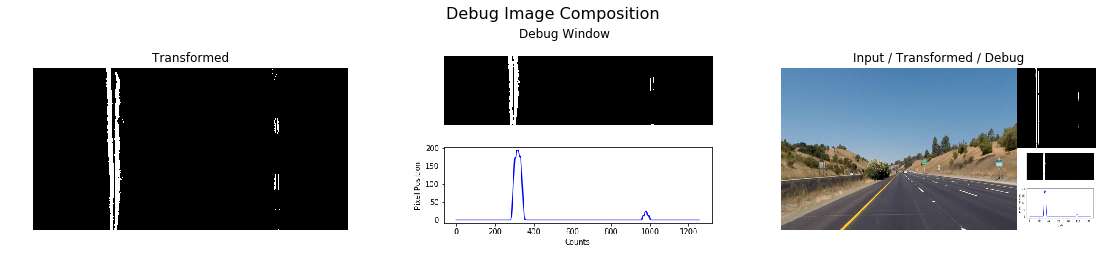

In [19]:
images_to_show = [example_thresh_image, thresh_debug_image, combined_image]
labels_to_show = ["Transformed", "Debug Window", "Input / Transformed / Debug"]
show_images(images_to_show, labels=labels_to_show, cols=len(images_to_show),
                title="Debug Image Composition")

### Detect lane pixels and fit to find the lane boundary

In [20]:
height, width = example_thresh_image.shape[:2]
ploty = np.linspace(0, height - 1, height)

In [21]:
histogram, _ = calc_moving_average_y(example_thresh_image)

In [22]:
(leftx, lefty, rightx, righty), (left_fit, right_fit), out_img = find_fitpolynomial(example_thresh_image, histogram)

In [23]:
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

### Determine the curvature of the lane and vehicle position with respect to center

In [24]:
left_radius = calculate_radius(leftx, lefty, ploty)
right_radius = calculate_radius(rightx, righty, ploty)
center_dist = calculate_distance_from_center(example_thresh_image, left_fit, right_fit)

In [25]:
print("left_radius: ", left_radius, "m")
print("right_radius: ", right_radius, "m")
print("distance from center: ", center_dist, "m")

left_radius:  3323.39322705 m
right_radius:  3076.72603325 m
distance from center:  -0.1 m


### Warp the detected lane boundaries back onto the original image

In [26]:
lane_space_image = draw_lane_space(example_test_image, example_thresh_image, Minv, left_fitx, right_fitx, ploty)

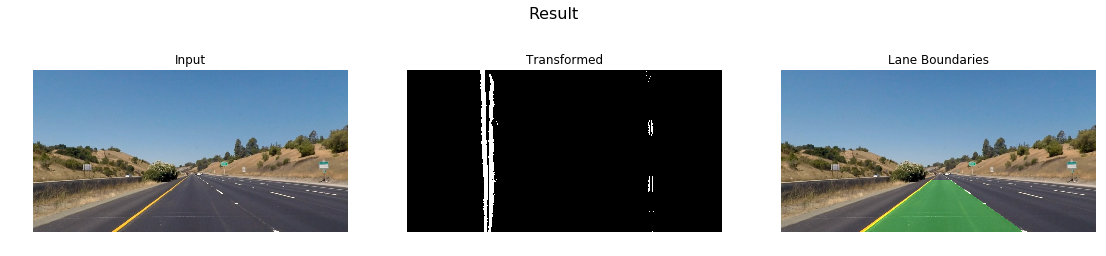

In [27]:
images_to_show = [example_test_image, example_thresh_image, lane_space_image]
labels_to_show = ["Input", "Transformed", "Lane Boundaries"]
show_images(images_to_show, labels=labels_to_show, cols=len(images_to_show),
                title="Result")

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [28]:
detector = LaneProcessor(objpoints, imgpoints)
result_image = detector.process(original_test_image)

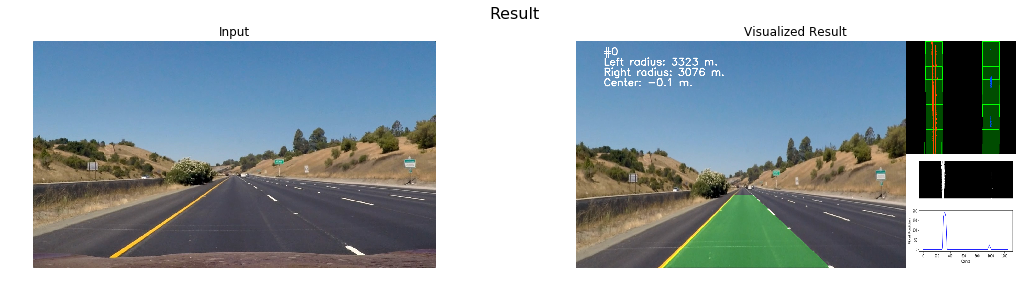

In [29]:
images_to_show = [original_test_image, result_image]
labels_to_show = ["Input", "Visualized Result"]
show_images(images_to_show, labels=labels_to_show, cols=len(images_to_show),
                title="Result")

### Video Results

In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{}">
</video>
""".format("output_images/out_project_video.mp4"))

In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{}">
</video>
""".format("output_images/out_challenge_video.mp4"))